# **instalasi pustaka**

In [ ]:
print("\nTrying to import deap")
try:
    import deap
except ImportError as exc:
    print("ImportError")
    print(exc)
    %pip install deap


Trying to import deap
ImportError
No module named 'deap'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
print("\nTrying to import toolbox")
try:
    import toolbox
except ImportError as exc:
    print("ImportError")
    print(exc)
    %pip install toolbox


Trying to import toolbox
ImportError
No module named 'toolbox'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print("\nTrying to import pymcdm")
try:
    import pymcdm
except ImportError as exc:
    print("ImportError")
    print(exc)
    %pip install pymcdm


Trying to import pymcdm
ImportError
No module named 'pymcdm'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 3.5 MB/s eta 0:00:00


# **impor pustaka**

In [ ]:
import math
import operator
import time

import random
from random import randrange

import numpy as np
import pandas as pd

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

from PIL import Image
from IPython.display import display

# **inisialisasi lidi**

In [ ]:
df_lidi = pd.read_excel('/content/motif-ulos.xlsx',
                        'lidi',
                        index_col = 0,
                        keep_default_na = False
                        )

In [ ]:
dict_lidi = df_lidi.T.to_dict('list')
# motif_width = int(input("Input lebar motif  : "))
motif_width = 22
half_motif_width = int(motif_width/2)

In [ ]:
# import random

# rows = 140
# cols = 140

# dict_lidi = {}
# for i in range(1, rows + 1):
#     row = [random.randint(0, 1) for _ in range(cols)]
#     dict_lidi[i] = row

# **implementasi PSO**


In [ ]:
random.seed(42)

*representasi*

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list,
               smin=None, smax=None, best=None)

*hyperparameter*

In [ ]:
pmin = min(dict_lidi.keys())
pmax = max(dict_lidi.keys())
npop = 50

*inisialisasi/ initializer*

In [ ]:
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.randrange(pmin, pmax) for _ in range(size))
    part.speed = [random.randrange(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax

    return part

*update/ updater*

In [ ]:
def updateParticle(part, best, phi1, phi2):
    u1 = (random.randrange(0, phi1) for _ in range(len(part)))
    u2 = (random.randrange(0, phi2) for _ in range(len(part)))

    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed,
                          map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)

    part[:] = list(map(operator.add, part, part.speed))

*evaluasi/ evaluator*

**1. composition fitness function**

---




In [ ]:
def composition_fitness(particle):
    matrix = [dict_lidi.get(position) for position in particle]
    white_cell = list(np.concatenate((matrix), axis=None)).count(1)
    black_cell = list(np.concatenate((matrix), axis=None)).count(0)
    total_cell = black_cell + white_cell

    if black_cell > white_cell:
        fitness_value = 1 / (black_cell / white_cell)
    else:
        fitness_value = black_cell / white_cell
    return round(fitness_value, 2),

# debugging
# p = [4, 3, 2, 3, 5, 6, 5, 6, 7, 4]
# print(composition_fitness(p))

**2. diagonal fitness function**

---



In [ ]:
def diagonal_fitness(particle):
    diagonal_score = 0
    n_sub_matrix = 0

    list_temp = []
    for position in particle:
        list_temp.append(dict_lidi.get(position))
    matrix = np.array(list_temp)
    for h in range(matrix.shape[0]-1):
        for w in range(matrix.shape[1]-1):
            index_array = np.ix_([h, h+1], [w, w+1])
            sub_matrix = matrix[index_array]
            if sub_matrix[0,0] == sub_matrix[1,1] and \
            sub_matrix[0,0] != sub_matrix[0,1] and \
            sub_matrix[0,0] != sub_matrix[1,0]:
                diagonal_score+=1
            n_sub_matrix+=1

    return (round(diagonal_score/n_sub_matrix, 2) if n_sub_matrix else 0),

**3. stick quantity fitness function**

---



In [ ]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def stick_quantity_fitness(particle):
    lp = len(particle)
    nus = len(set(particle))
    nus_norm = (nus - lp) / (lp - 1)
    ofv = int(nus * 0.3)

    if nus <= ofv:
        res = 1 - (ofv * 0.2)
    else:
        res = sigmoid(nus / ofv) if ofv else 0
    return round(res, 2),



**4. (composition, diagonal, stick quantity) fitness function**

---

In [ ]:
def combination_fitness(particle):
    a = composition_fitness(particle)[0]
    b = diagonal_fitness(particle)[0]
    c = stick_quantity_fitness(particle)[0]
    return round((a + b + c) / 3, 2),

*lanjutan dari evaluasi/evaluator*

In [ ]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=half_motif_width,
                 pmin=pmin, pmax=pmax, smin=-1, smax=1)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2, phi2=2)

In [ ]:
# membuat toolbox dengan nama evaluate
# toolbox.register("evaluate", benchmarks.h1)
toolbox.register("evaluate", composition_fitness)
# toolbox.register("evaluate", diagonal_fitness)
# toolbox.register("evaluate", stick_quantity_fitness)
# toolbox.register("evaluate", combination_fitness)

# **algoritma PSO**

In [ ]:
def main():
    pop = toolbox.population(n=npop)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    GEN = 500
    best = None

    for g in range(GEN):

        for id_part, part in enumerate(pop):
            for id_pos, pos in enumerate(part):
                if pos < pmin:
                    part[id_pos] = int(pmin)
                elif pos > pmax:
                    part[id_pos] = int(pmax)
                else:
                    part[id_pos] = int(pos)
            pop[id_part] = part

            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values

        for part in pop:
            toolbox.update(part, best)

        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))

        print("Generasi", g)
        for id_part, part in enumerate(pop):
            print("Partikel", str(id_part) + ":", part)
        print("---")

    print("\nGenerasi Terakhir")
    for id_part, part in enumerate(pop):
        print("Partikel", str(id_part) + ":", part)
    print("\nPartikel Terbaik pada Generasi Terakhir")
    print(best)

    if g == GEN - 1:
            print("Generasi", g)
            for id_part, part in enumerate(pop):
                part_stat = stats.compile([part])
                print(f"Partikel {id_part}: {part}\nStatistik: {part_stat}")
            print("---")

    return pop, logbook, best

if __name__ == "__main__":
    start = time.time()
    pop, logbook, best = main()
    end = time.time()
    print("\n"+"Populasi Akhir")
    print(pop)
    print("\n"+"Logbook")
    print(logbook)
    print("\n"+"Partikel Terbaik")
    print(best)
    print("\n"+"Waktu Pencarian")
    total_time = end - start
    print(str(total_time) + " detik")

Streaming output truncated to the last 5000 lines.
Partikel 36: [12.0, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 37: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 38: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 39: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 12.0, 12.0, 12.0, 12.0]
Partikel 40: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 41: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 42: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 43: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 44: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 45: [12.0, 12.0, 12.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 46: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Partikel 47: [12.0, 12.0, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0,

In [ ]:
motif_matrix = [dict_lidi.get(
    i) for i in best]

# **konversi matrix menjadi gambar motif ulos**

In [ ]:
def translate(code):
    width, height = 25, 25
    if code == 0:
        matrix = np.zeros((height, width, 3), dtype= np.uint8)
    else:
        matrix = np.full((height, width, 3), 255, dtype=np.uint8)
        matrix[0:height, 0:1] = [0, 0, 0]
        matrix[0:height, width-1: width] = [0, 0, 0]
        matrix[0:1, 0:width] = [0,0,0]
        matrix[height-1:height, 0:width] = [0,0,0]

    return matrix

In [ ]:
def seam_horizontal(matrix_a, matrix_b):
    data = np.concatenate((matrix_a, matrix_b), axis=1)

    return data

In [ ]:
def seam_vertical(matrix_a, matrix_b):
    data = np.concatenate((matrix_a, matrix_b), axis=0)

    return data

In [ ]:
def generate_motif(matrix):
    width = len(motif_matrix[0]) * 25
    height = len(motif_matrix) * 25

    final_matrix = np.empty((height, width, 3), dtype=np.uint8)

    for idx1, ele1 in enumerate(matrix):
        if idx1 > 0:
            matrix = np.empty((25, 25, 3), dtype=np.uint8)
            for idx2, ele2 in enumerate(ele1):
                if idx2 > 0:
                    matrix = seam_horizontal(matrix, translate(ele2))
                else:
                    matrix = translate(ele2)
            final_matrix = seam_vertical(final_matrix, matrix)
        else:
            matrix = np.empty((25, 25, 3), dtype=np.uint8)
            for idx2, ele2 in enumerate(ele1):
                if idx2 > 0:
                    matrix = seam_horizontal(matrix, translate(ele2))
                else:
                    matrix = translate(ele2)
            final_matrix = matrix

    return final_matrix

In [ ]:
def matrix2image(matrix):
    return Image.fromarray(matrix, 'RGB')

In [ ]:
def mirrormatrix(matrix):
    top_matrix = generate_motif(matrix)
    bottom_matrix = np.flip(top_matrix, axis=0)
    matrix = np.concatenate((top_matrix, bottom_matrix), axis=0)
    return matrix

In [ ]:
print(np.shape(motif_matrix))

(11, 140)


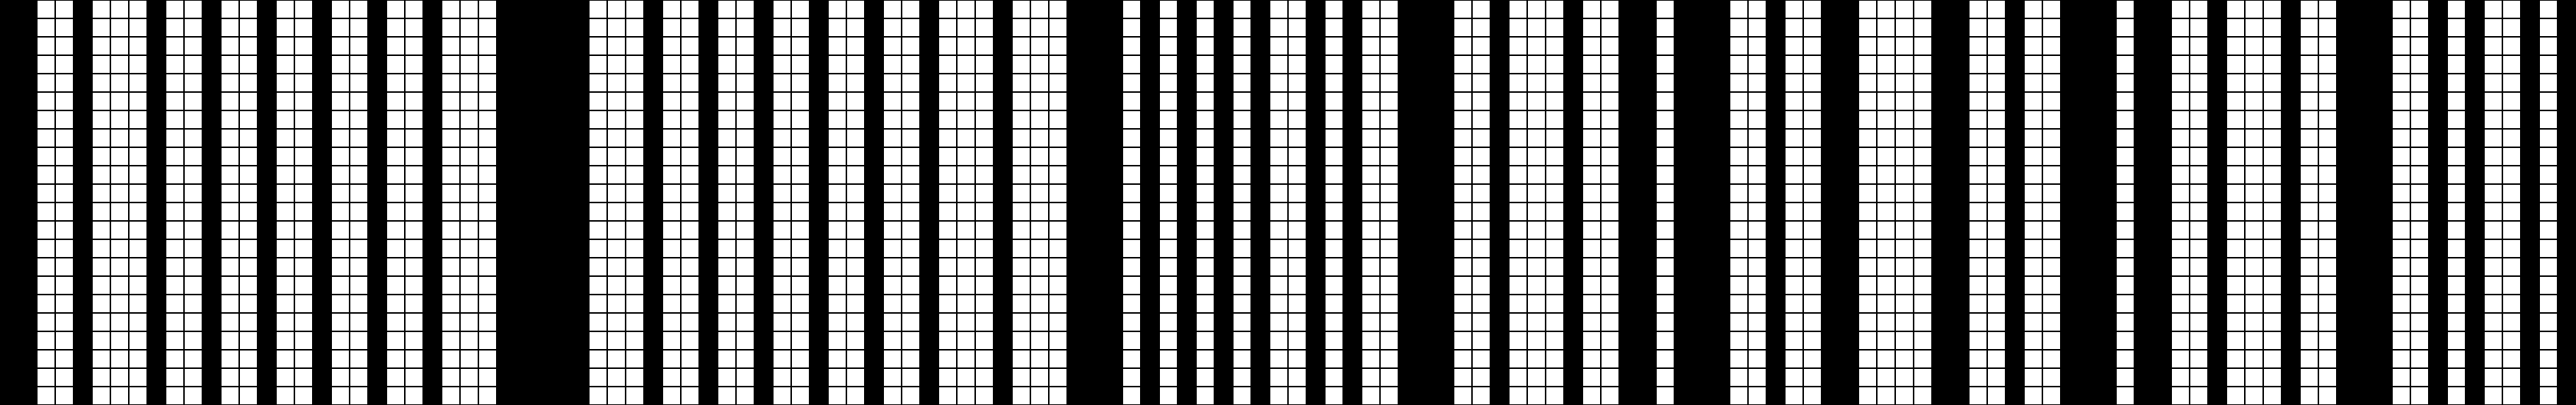

In [ ]:
display(matrix2image(mirrormatrix(motif_matrix)))

In [ ]:
# import pandas as pd

# df = pd.DataFrame(logbook, columns=['gen', 'max'])

# # Simpan DataFrame ke dalam file Excel
# df.to_excel('iterasi200_ff1.xlsx', index=False)

# **evaluasi TOPSIS**

In [ ]:
fitness_value = composition_fitness(best)
print(fitness_value)

(0.75,)


In [ ]:
fv11 = composition_fitness(best)
fv12 = diagonal_fitness(best)
fv13 = stick_quantity_fitness(best)
fv14 = combination_fitness(best)

In [ ]:
output_list = [fv11, fv12, fv13, fv14]
print(output_list)

[(0.75,), (0.0,), (0,), (0.25,)]


In [ ]:
# fv21 = composition_fitness(best)
# fv22 = diagonal_fitness(best)
# fv23 = stick_quantity_fitness(best)
# fv24 = combination_fitness(best)

In [ ]:
# output_list = [fv21, fv22, fv23, fv24]
# print(output_list)

In [ ]:
# fv31 = composition_fitness(best)
# fv32 = diagonal_fitness(best)
# fv33 = stick_quantity_fitness(best)
# fv34 = combination_fitness(best)

In [ ]:
# output_list = [fv31, fv32, fv33, fv34]
# print(output_list)

In [ ]:
# fv41 = composition_fitness(best)
# fv42 = diagonal_fitness(best)
# fv43 = stick_quantity_fitness(best)
# fv44 = combination_fitness(best)

In [ ]:
# output_list = [fv41, fv42, fv43, fv44]
# print(output_list)

In [ ]:
!pip install pymcdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **pymcdm**

In [ ]:
# import numpy as np
# from pymcdm import methods as mcdm_methods
# from pymcdm import weights as mcdm_weights
# from pymcdm.helpers import rrankdata

# matrix = np.array([
#     [fv11, fv12, fv13, fv14],
#     [fv21, fv22, fv23, fv24],
#     [fv31, fv32, fv33, fv34],
#     [fv41, fv42, fv43, fv44]
# ])

In [ ]:
# data_squeezee = np.squeeze(matrix)

In [ ]:
# print(data_squeezee)

**Weights**

We would use equal weight for criteria:

In [ ]:
# weights = mcdm_weights.equal_weights(data_squeezee)

In [ ]:
# print(weights)

**Criteria types**

Functions in pymcdm library use types argument to determine which criteria are profit and should be maximized and which criteria are cost and should be minimized. 1 means profit criteria and −1 means cost criteria. For this particular decision problem types vector would be defined as follows:

In [ ]:
# types = np.array([1, 1, 1, 1])

**TOPSIS method**

**Important:** You cannot use this methods if one of criterions in the problem has equal values for each alternatives. Consider use another method or delete this criterion.

In [ ]:
import numpy as np
# Suppress/hide the warning
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
raw_data = np.array([
    [0.36, 0.17, 0.98, 0.5],
    [0.36, 0.17, 0.98, 0.5],
    [0.35, 0.13, 1, 0.49],
    [0.36, 0.17, 0.98, 0.5],
])

In [ ]:
def calculate(matrix):
    # 1. Mengkonversikan data ke dalam bentuk fuzzy
    new_matrix = matrix**2
    # print(new_matrix)
    # print(new_matrix.sum(axis=0))
    # print(np.sqrt(new_matrix.sum(axis=0)))

    # 2. Menghitung matriks yang ternormalisasi
    x = (np.sqrt(new_matrix.sum(axis=0)))
    r = [row / x[id] for id, row in enumerate(matrix.T)]

    # 3.Menghitung matriks yang ternomalisasi yang terbobot (Y)
    # Untuk bobot yang sudah ditentukan (W)
    w = np.array([0.25, 0.25, 0.25, 0.25])
    y = np.array([(row * w[id]) for id, row in enumerate(r)])

    # 4. Menentukan Solusi Ideal Positif (A+)
    # dan Matriks Ideal Negatif (A-)
    a_plus = np.array([max(i) for i in y])
    a_minus = np.array([min(i) for i in y])

    # 5. Menghitung Jarak Solusi Ideal Positif (D+)
    # dan Solusi Ideal Negatif (D-)
    d_plus = np.sqrt(np.sum((y - a_plus)**2, axis=1))
    d_minus = np.sqrt(np.sum((y - a_minus)**2, axis=1))

    # d_plus = np.array([(a_plus-i)**2 for i in y.T]).sum(axis=0)
    # d_minus = np.array([(a_minus-i)**2 for i in y.T]).sum(axis=0)

    # 6. Menghitung Nilai Preferensi untuk setiap alternatif
    v = (d_minus / (d_minus + d_plus))
    # print(v)

    return x, r, w, y, a_plus, a_minus, d_plus, d_minus, v

# calculate(raw_data)

In [ ]:
x, r, w, y, a_plus, a_minus, d_plus, d_minus, v = calculate(raw_data)

In [ ]:
import numpy as np

# Mengurutkan indeks dalam urutan menurun berdasarkan nilai-nilai v
rangking = np.argsort(v)[::-1]

# Cetak hasil peringkat dengan format yang diinginkan
for i, idx in enumerate(rangking):
    print(f"alternative  {idx+1} is rangking {i+1}  with preference value of {v[idx]}")

alternative  4 is rangking 1  with preference value of 0.7704331405253732
alternative  1 is rangking 2  with preference value of 0.7679831176888291
alternative  3 is rangking 3  with preference value of 0.7488918373298956
alternative  2 is rangking 4  with preference value of 0.5996231231850189
